In [25]:
!pip install dask[complete] --quiet


In [26]:
import dask.dataframe as dd
import pandas as pd


In [27]:
df_excel = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df_excel.to_csv("retail_2010_2011.csv", index=False)


In [28]:
df = dd.read_csv("retail_2010_2011.csv")


In [76]:
df = df.dropna(subset=["Customer ID"])
df = df[~df["Invoice"].astype(str).str.startswith("C")]
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Total price column
df["TotalPrice"] = df["Quantity"] * df["Price"]


In [30]:
df = dd.read_csv("retail_2010_2011.csv", dtype={'Invoice': 'object'})


In [33]:
#conversion to datetime
df["InvoiceDate"] = dd.to_datetime(df["InvoiceDate"], errors='coerce')

#reference date
reference_date = df["InvoiceDate"].max().compute() + pd.Timedelta(days=1)

#recency
recency = df.groupby("Customer ID")["InvoiceDate"].max().reset_index()
recency["Recency"] = (reference_date - recency["InvoiceDate"]).dt.days

#lifespan
lifespan = df.groupby("Customer ID")["InvoiceDate"].agg(["min", "max"]).reset_index()
lifespan["Lifespan"] = (lifespan["max"] - lifespan["min"]).dt.days


#freq
frequency = df[["Customer ID", "Invoice"]].drop_duplicates()
frequency = frequency.groupby("Customer ID").size().reset_index()
frequency = frequency.rename(columns={0: "Frequency"})


#monetary
monetary = df.groupby("Customer ID")["TotalPrice"].sum().reset_index()
monetary = monetary.rename(columns={"TotalPrice": "Monetary"})

#totalitems
items = df.groupby("Customer ID")["Quantity"].sum().reset_index()
items = items.rename(columns={"Quantity": "TotalItems"})


# Merge
others = frequency.merge(monetary, on="Customer ID").merge(items, on="Customer ID")
rfm = recency.merge(lifespan[["Customer ID", "Lifespan"]], on="Customer ID")
rfm = rfm.merge(others, on="Customer ID")
rfm["AvgBasketSize"] = rfm["TotalItems"] / rfm["Frequency"]
rfm["AvgSpendPerInvoice"] = rfm["Monetary"] / rfm["Frequency"]


rfm.head()


,Customer ID,InvoiceDate,Recency,Lifespan,Frequency,Monetary,TotalItems,AvgBasketSize,AvgSpendPerInvoice
0,12346.0,2011-01-18 10:01:00,326,0,1,77183.60,74215,74215.000000,77183.600000
1,12347.0,2011-12-07 15:52:00,2,365,7,4310.00,2458,351.142857,615.714286
2,12348.0,2011-09-25 13:13:00,75,282,4,1797.24,2341,585.250000,449.310000
3,12349.0,2011-11-21 09:51:00,19,0,1,1757.55,631,631.000000,1757.550000
4,12350.0,2011-02-02 16:01:00,310,0,1,334.40,197,197.000000,334.400000


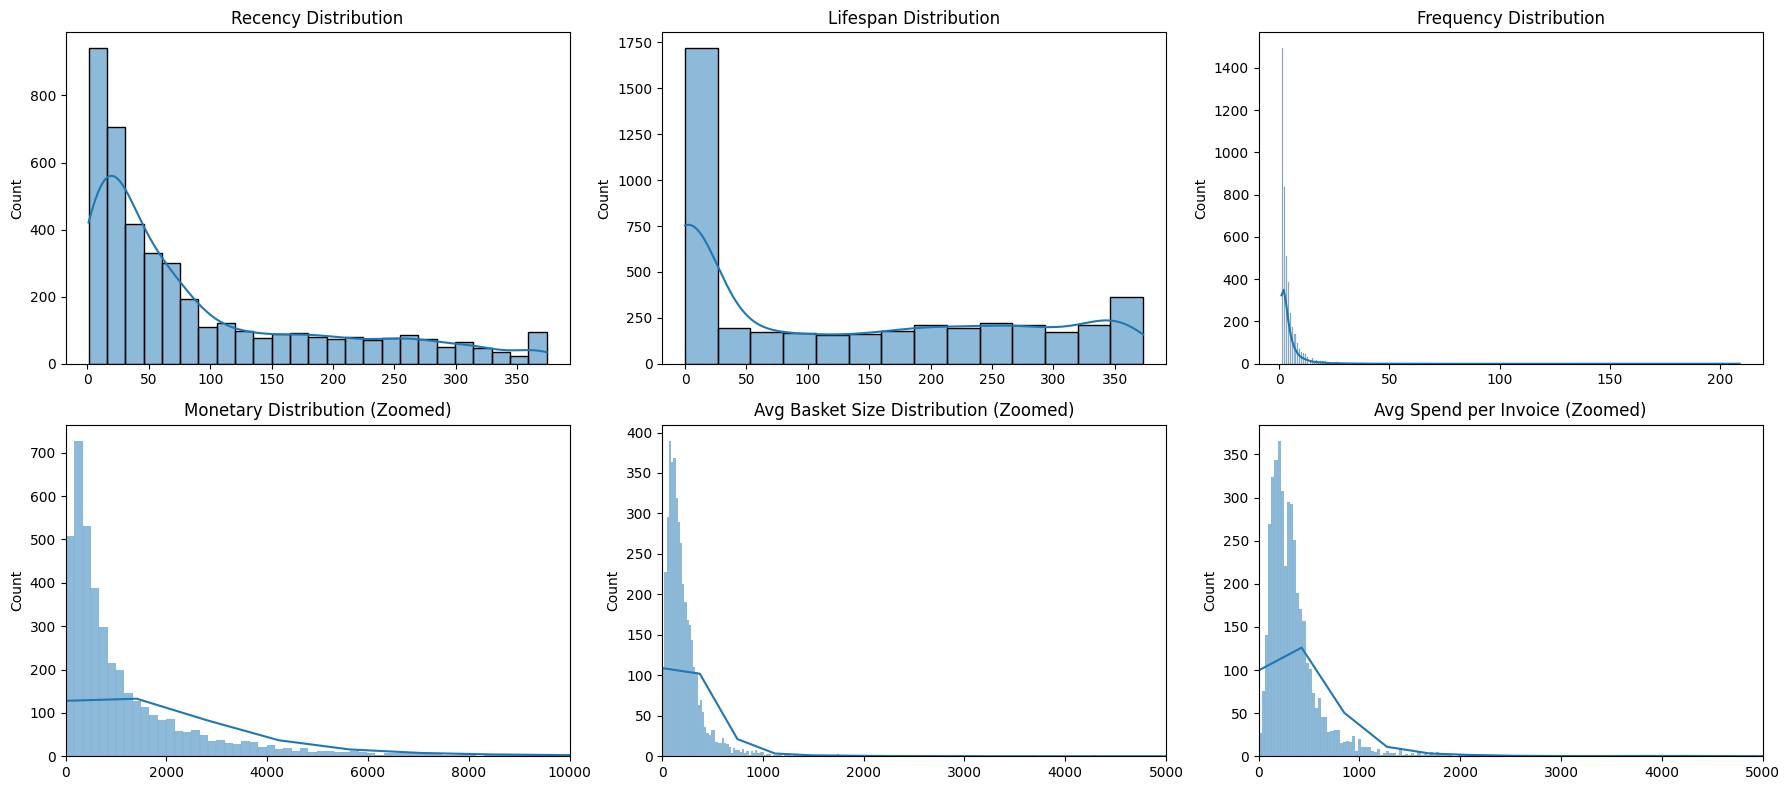

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_pd = rfm.copy()

# Create 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

sns.histplot(rfm_pd["Recency"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Recency Distribution")

sns.histplot(rfm_pd["Lifespan"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Lifespan Distribution")

sns.histplot(rfm_pd["Frequency"], kde=True, ax=axes[0, 2])
axes[0, 2].set_title("Frequency Distribution")

sns.histplot(rfm_pd["Monetary"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Monetary Distribution (Zoomed)")
axes[1, 0].set_xlim(0, 10000)  # Adjust based on your data

sns.histplot(rfm_pd["AvgBasketSize"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Avg Basket Size Distribution (Zoomed)")
axes[1, 1].set_xlim(0, 5000)

sns.histplot(rfm_pd["AvgSpendPerInvoice"], kde=True, ax=axes[1, 2])
axes[1, 2].set_title("Avg Spend per Invoice (Zoomed)")
axes[1, 2].set_xlim(0, 5000)

plt.tight_layout()
plt.show()


RFM Scoring

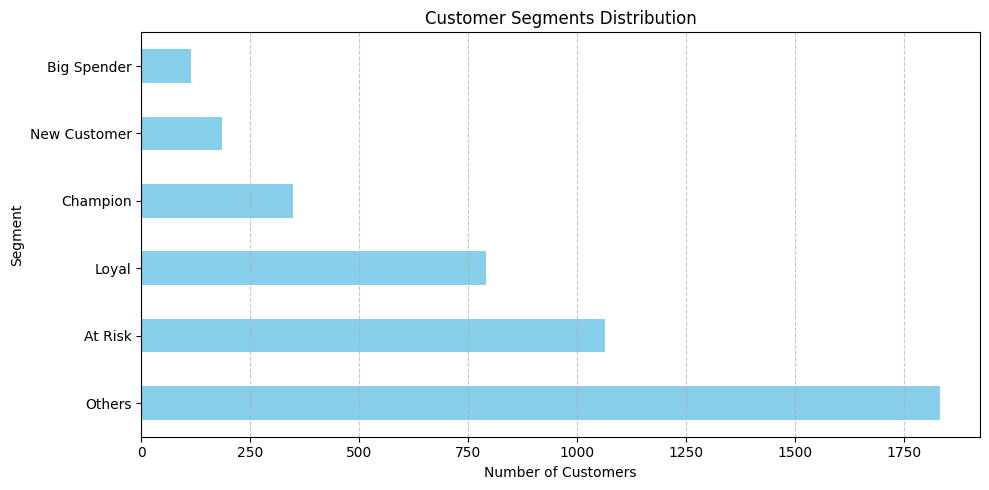

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

rfm_pd = rfm.compute()
#RFM Scoring using quantiles
rfm_pd["R_Score"] = pd.qcut(rfm_pd["Recency"], 5, labels=[5, 4, 3, 2, 1])

rfm_pd["F_Score"] = pd.qcut(rfm_pd["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_pd["M_Score"] = pd.qcut(rfm_pd["Monetary"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# combining into single RFM score
rfm_pd["RFM_Score"] = (
    rfm_pd["R_Score"].astype(str) +
    rfm_pd["F_Score"].astype(str) +
    rfm_pd["M_Score"].astype(str)
)

# segment mapping based on scores
def segment_customer(row):
    if row["RFM_Score"] == "555":
        return "Champion"
    elif row["R_Score"] >= 4 and row["F_Score"] >= 4:
        return "Loyal"
    elif row["R_Score"] >= 4 and row["M_Score"] >= 4:
        return "Big Spender"
    elif row["R_Score"] == 5:
        return "New Customer"
    elif row["R_Score"] <= 2 and row["F_Score"] <= 2:
        return "At Risk"
    else:
        return "Others"

rfm_pd["Segment"] = rfm_pd.apply(segment_customer, axis=1)

#isualizing segment distribution
plt.figure(figsize=(10, 5))
rfm_pd["Segment"].value_counts().plot(kind="barh", color="skyblue")
plt.title("Customer Segments Distribution")
plt.xlabel("Number of Customers")
plt.ylabel("Segment")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipython-input-51-2283130028.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_pd, x="Segment", order=rfm_pd["Segment"].value_counts().index, palette="viridis")


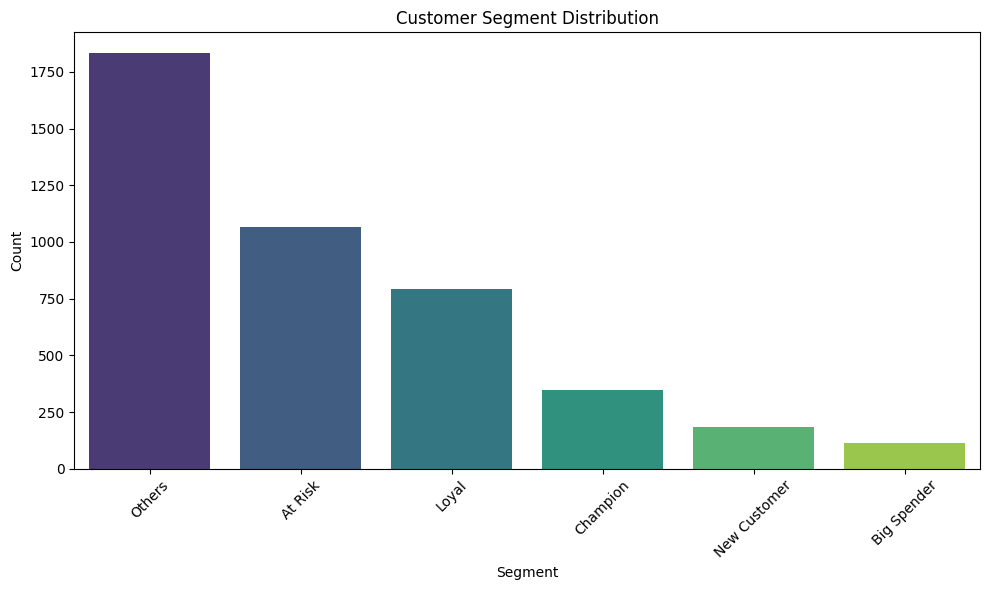

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_pd, x="Segment", order=rfm_pd["Segment"].value_counts().index, palette="viridis")
plt.title("Customer Segment Distribution")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [52]:
segment_stats = rfm_pd.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean().round(2)
display(segment_stats.sort_values(by="Monetary", ascending=False))


,Recency,Frequency,Monetary
Segment,,,
Champion,5.45,18.24,11221.74
Big Spender,16.73,2.41,3101.54
Loyal,16.77,6.36,2556.99
Others,82.36,2.93,1107.17
At Risk,217.90,1.10,487.71
New Customer,7.06,1.78,420.21


In [53]:
rfm_pd.to_csv("rfm_segmented_customers.csv", index=False)


Clustering Based Segmentaion using KMeans

In [54]:
from sklearn.preprocessing import StandardScaler

rfm_clustering = rfm_pd[["Recency", "Frequency", "Monetary"]]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)


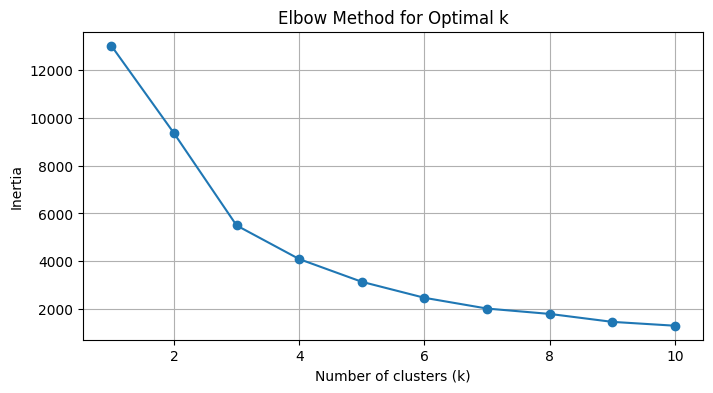

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = rfm_pd[['Recency', 'Frequency', 'Monetary', 'Lifespan', 'AvgBasketSize', 'AvgSpendPerInvoice']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_pd['Cluster'] = kmeans.fit_predict(features_scaled)

print(rfm_pd['Cluster'].value_counts())


Cluster
2    2443
0    1868
3      25
1       2
Name: count, dtype: int64


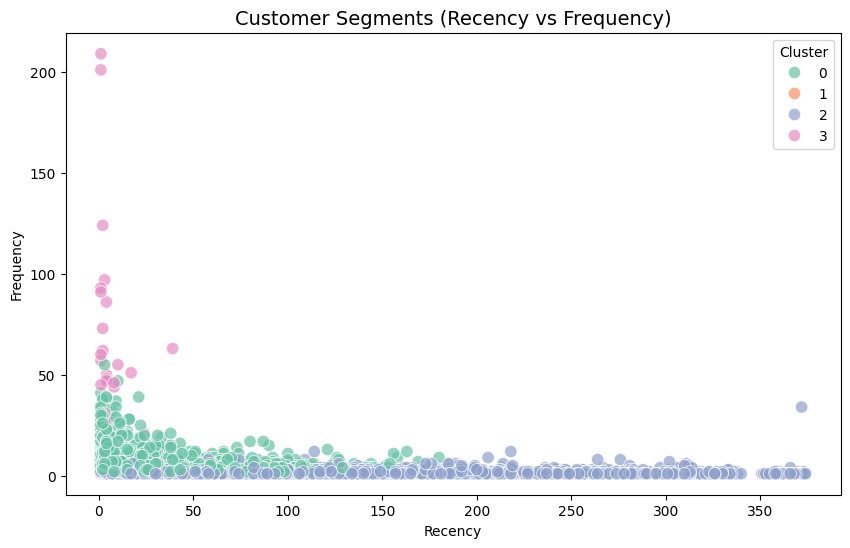

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_pd, x='Recency', y='Frequency', hue='Cluster', palette='Set2', alpha=0.7, s=80)
plt.title('Customer Segments (Recency vs Frequency)', fontsize=14)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()


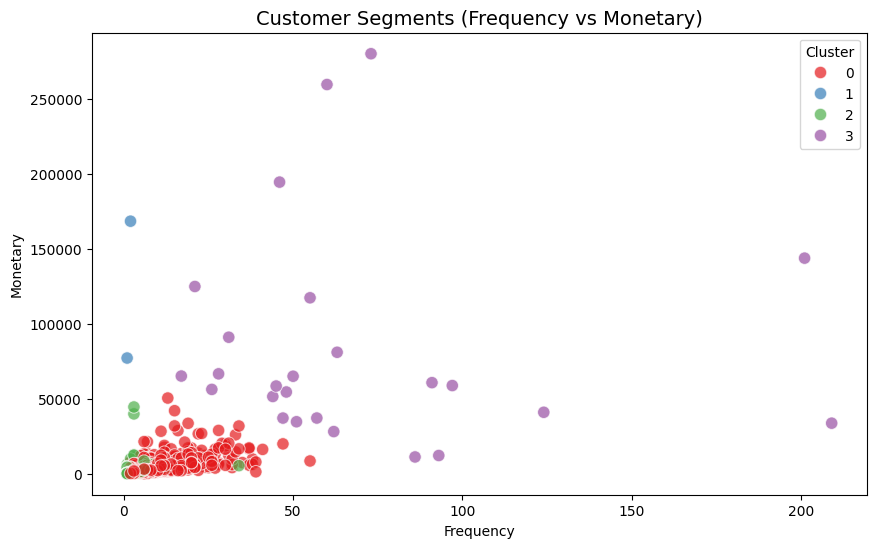

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_pd, x='Frequency',y='Monetary', hue='Cluster', palette='Set1', alpha=0.7, s=80)
plt.title('Customer Segments (Frequency vs Monetary)', fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()


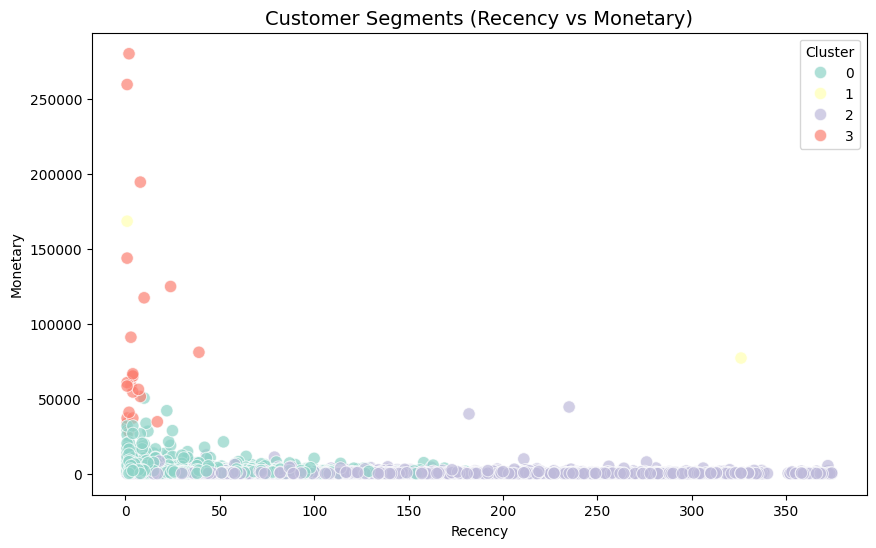

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_pd, x='Recency', y='Monetary', hue='Cluster', palette='Set3', alpha=0.7, s=80)
plt.title('Customer Segments (Recency vs Monetary)', fontsize=14)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()


In [61]:
cluster_profile = rfm_pd.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Lifespan', 'AvgBasketSize', 'AvgSpendPerInvoice']].mean().round(1)
cluster_profile['Count'] = rfm_pd['Cluster'].value_counts()
print(cluster_profile.sort_values(by='Count', ascending=False))



         Recency  Frequency  Monetary  Lifespan  AvgBasketSize  \
Cluster                                                          
2          139.1        1.7     617.5      26.9          216.4   
0           32.7        6.8    2726.0     262.9          231.4   
3            6.2       69.0   82601.6     351.3          952.5   
1          163.5        1.5  122828.0     102.0        57356.8   

         AvgSpendPerInvoice  Count  
Cluster                             
2                     366.5   2443  
0                     384.5   1868  
3                    1732.2     25  
1                   80709.9      2  


/tmp/ipython-input-62-3009963351.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_plot_df['Cluster'] = cluster_plot_df['Cluster'].astype(str)  # convert to string for color grouping


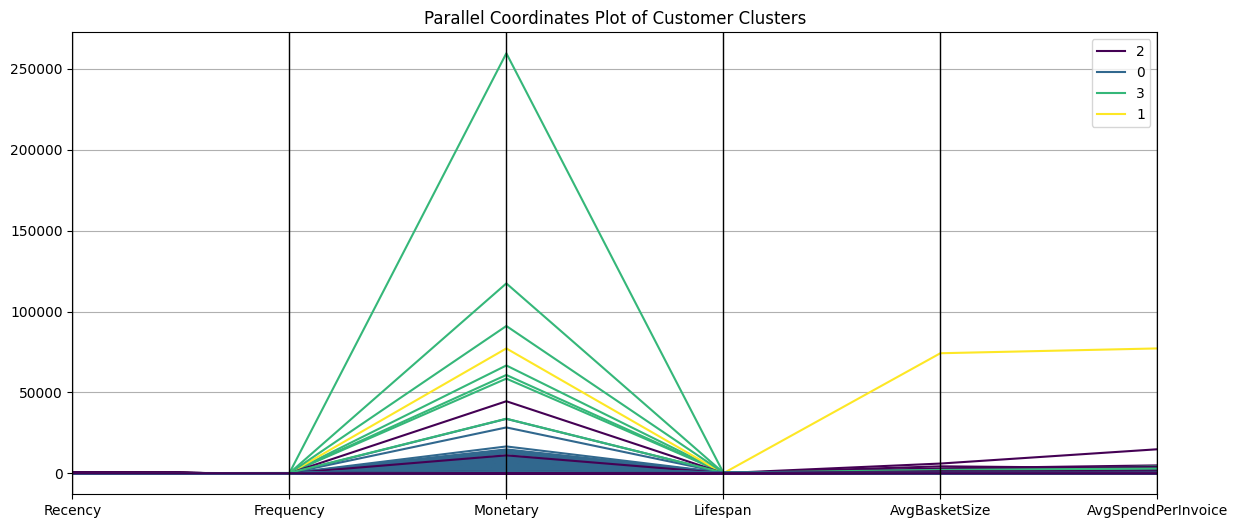

In [62]:
from pandas.plotting import parallel_coordinates

cluster_plot_df = rfm_pd[['Recency', 'Frequency', 'Monetary', 'Lifespan', 'AvgBasketSize', 'AvgSpendPerInvoice', 'Cluster']]
cluster_plot_df['Cluster'] = cluster_plot_df['Cluster'].astype(str)  # convert to string for color grouping

plt.figure(figsize=(14, 6))
parallel_coordinates(cluster_plot_df.sample(1000), class_column='Cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot of Customer Clusters')
plt.show()


/tmp/ipython-input-70-4054151155.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


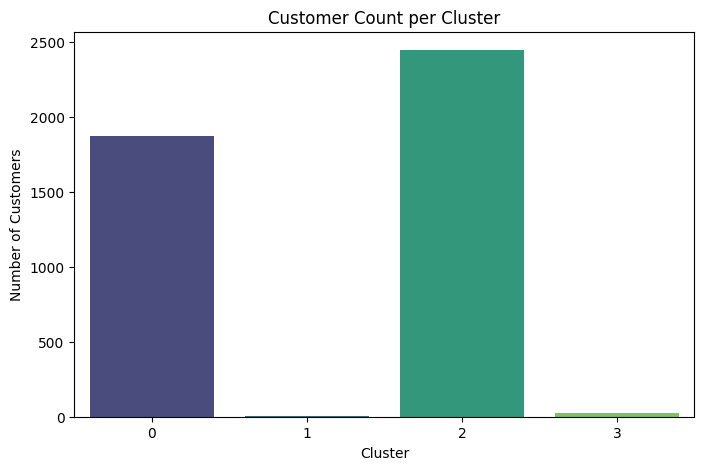

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_counts = rfm_pd['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


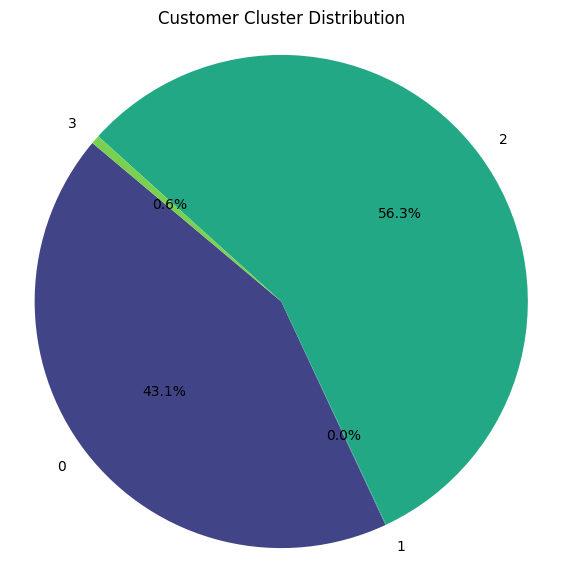

In [71]:
# Pie chart
plt.figure(figsize=(7,7))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(cluster_counts)))
plt.title('Customer Cluster Distribution')
plt.axis('equal')
plt.show()


Insights

1. Cluster 3: VIP Loyal Customers

Extremely high frequency and monetary value.
Very active recently.
Small group (25 customers) but very valuable.

Action : Consider loyalty programs, exclusive deals.

2. Cluster 0: Regular Shoppers

Buy frequently and recently.
Moderate lifetime value.

Action : Target them with regular promotions and retain them.

3. Cluster 2: Inactive or At-Risk Customers
Haven’t shopped recently, very low spending.
Large in number.

Action : Focus on re-engagement: discounts, reminders, email campaigns.

4. Cluster 1: High Rollers / Corporate Clients (Possibly Anomalies)

Very high basket and invoice value, but few in count.
Possibly bulk or one-time buyers.

Action : Review their behavior manually, could be outliers or wholesale buyers.

# Predictive Modelling

In [77]:
list(rfm_pd.columns)

['Customer ID',
 'InvoiceDate',
 'Recency',
 'Lifespan',
 'Frequency',
 'Monetary',
 'TotalItems',
 'AvgBasketSize',
 'AvgSpendPerInvoice',
 'R_Score',
 'F_Score',
 'M_Score',
 'RFM_Score',
 'Segment',
 'Cluster']

In [79]:
#CLV for each customer
rfm_pd['CLV'] = rfm_pd['AvgSpendPerInvoice'] * rfm_pd['Frequency'] * rfm_pd['Lifespan']


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [81]:
# Features for prediction
features = ['Recency', 'Frequency', 'Monetary', 'Lifespan',
            'AvgSpendPerInvoice', 'AvgBasketSize', 'Cluster']

# Target variable
target = 'CLV'

X = rfm_pd[features]
y = rfm_pd[target]


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)



In [83]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [84]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 49274.21
Root Mean Squared Error (RMSE): 570159.36
R² Score: 0.9759


/tmp/ipython-input-88-430870653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='coolwarm')


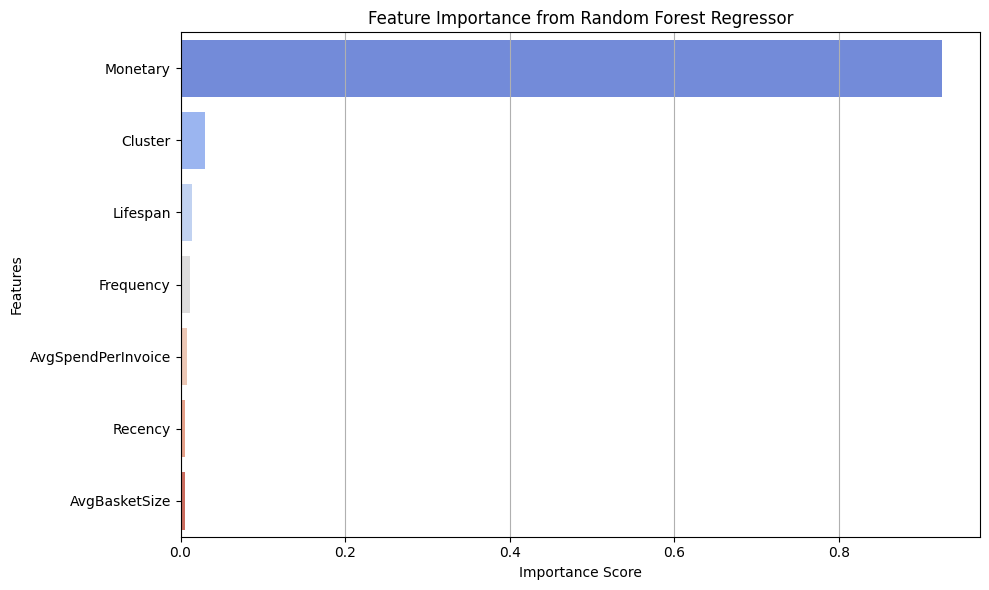

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='coolwarm')
plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.grid(axis='x')
plt.show()


In [85]:
rfm_pd['Predicted_CLV'] = model.predict(rfm_pd[features])


Actual vs Predicted



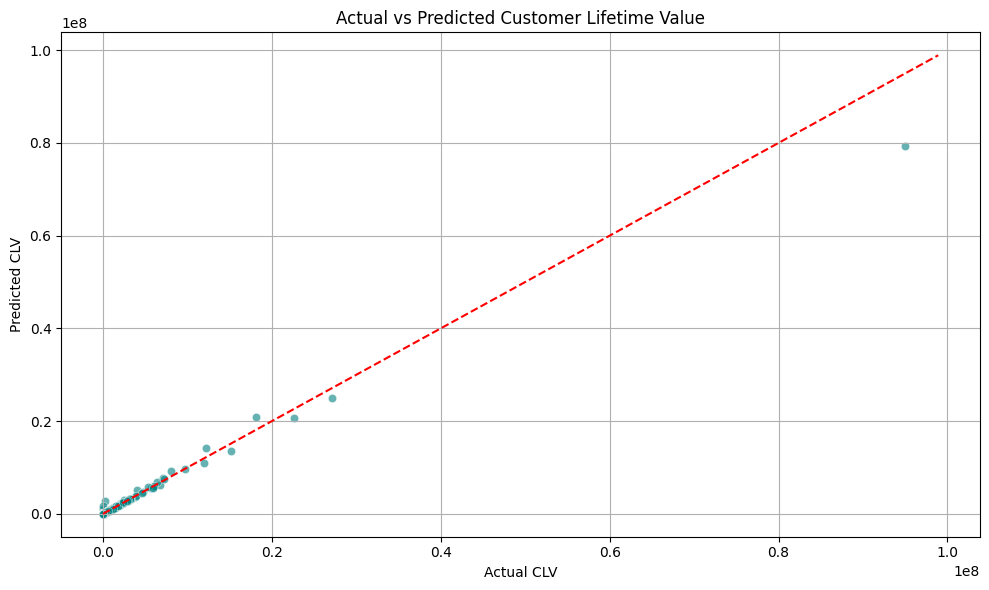

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')  # Line y=x for reference
plt.grid(True)
plt.tight_layout()
plt.show()



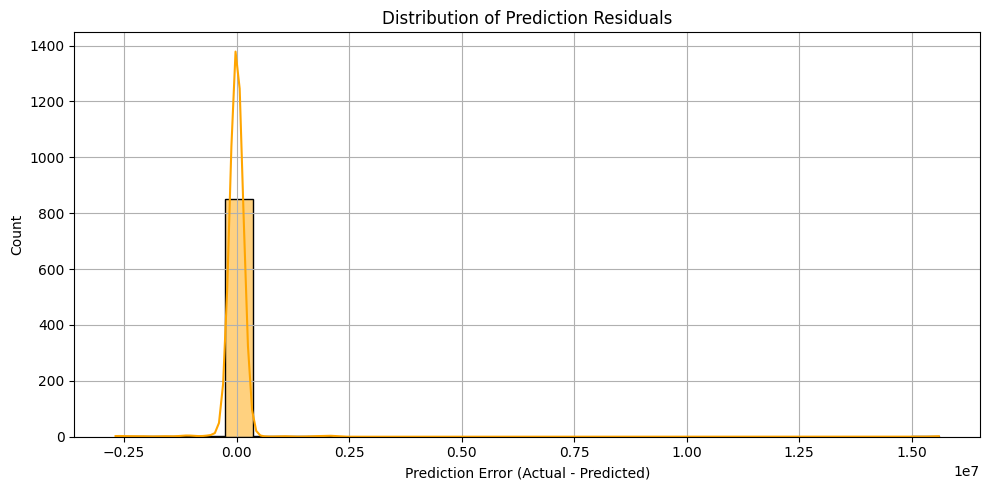

In [87]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Distribution of Prediction Residuals")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


Monetary value was found to be the most influential feature in predicting Customer Lifetime Value (CLV), indicating that past spending is a strong predictor of future value.”
